In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import numpy as np
import h5py

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d

from scipy.signal import hilbert, medfilt
from copy import deepcopy

# import seaborn as sns
# sns.set(style="white", palette="muted", color_codes=True)

In [3]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


# Read in a real waveform

In [4]:
waveforms = dict()
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    
    with h5py.File('../data/waveforms/waveforms_3s_{}_testing.h5'.format(dist), 'r') as file:
        waveforms_ = np.array(file['waveforms'])
        failed_ = np.array(file['failed'])
        waveforms[dist] = np.array([waveforms_[i] for i in range(len(waveforms_)) if i not in failed_])

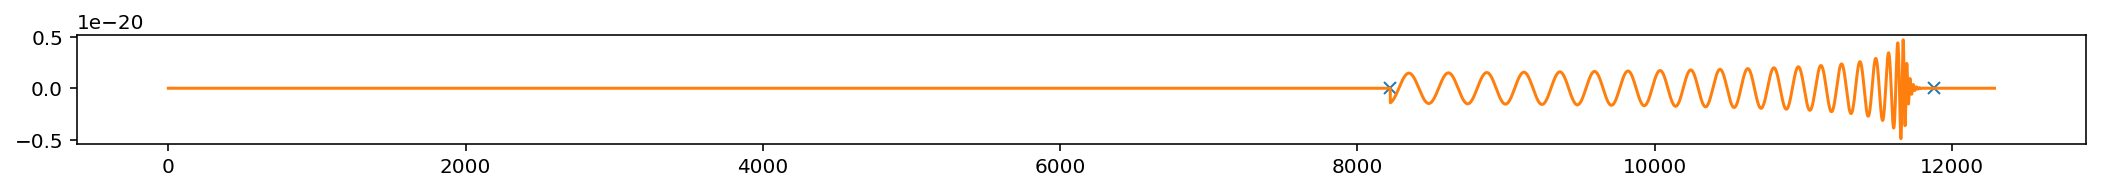

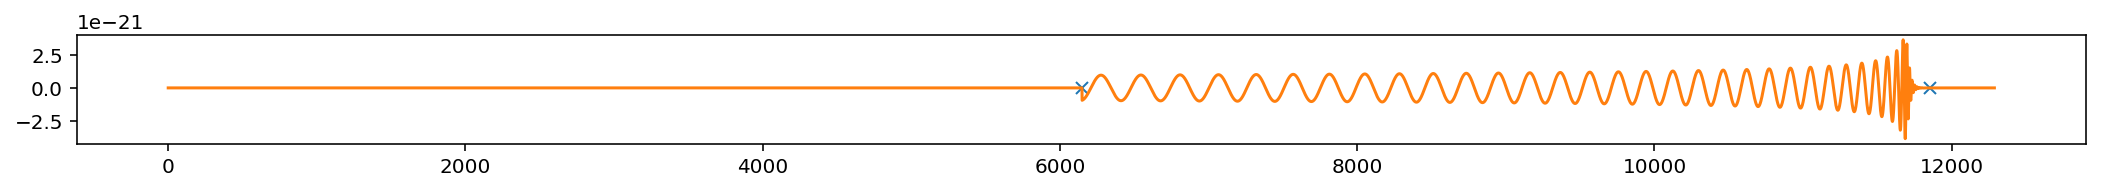

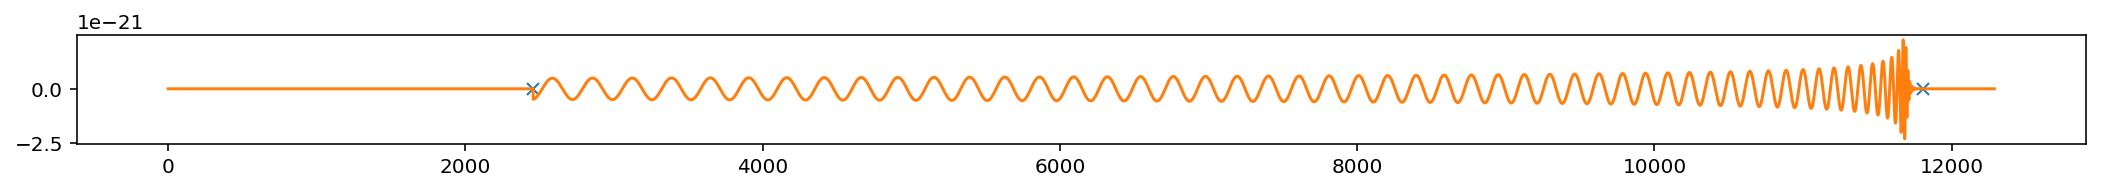

In [5]:
def get_start_end_idx(waveform):

    start = None
    end = None
    for j in range(len(waveform)):
        if waveform[j] != 0:
            start = j
            break
    for j in range(len(waveform))[::-1]:
        if waveform[j] != 0:
            end = j
            break
    
    return start, end


# Plot some of the loudest waveforms, just for fun
for i in range(3):
    
    waveform = waveforms['0100_0300'][i]
    
    start, end = get_start_end_idx(waveform)
    plt.plot([start, end], [0, 0], 'x')
    
    plt.plot(waveform)
    plt.gcf().set_size_inches(18, 1, forward=True)
    plt.show()

In [6]:
def get_envelope(signal):
    
    # Pad the signal with zeros at the beginning and end to reduce edge effects
    padded_signal = np.pad(signal, 100, 'constant', constant_values=0)
    
    # Calculate the raw envelope using the Hilbert transformation
    analytic_signal = hilbert(padded_signal)
    amplitude_envelope = np.abs(analytic_signal)

    # Smoothen the envelope using a median filter and a rolling average
    smooth = amplitude_envelope
    smooth[0:200] = medfilt(smooth[0:200], kernel_size=25)
    smooth = np.convolve(smooth, np.ones(10), mode='same') / 10
    
    # Remove the zero padding again to match the original signal length
    result = smooth[100:-100]
    
    return result

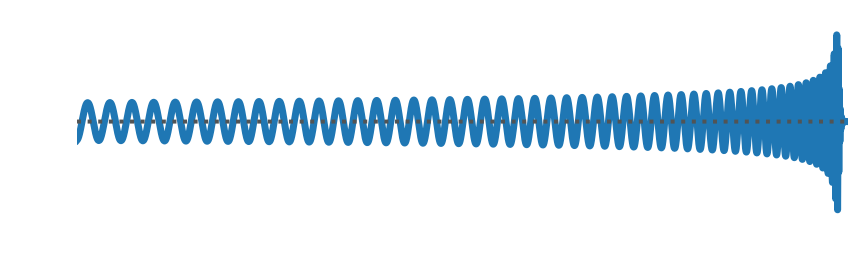

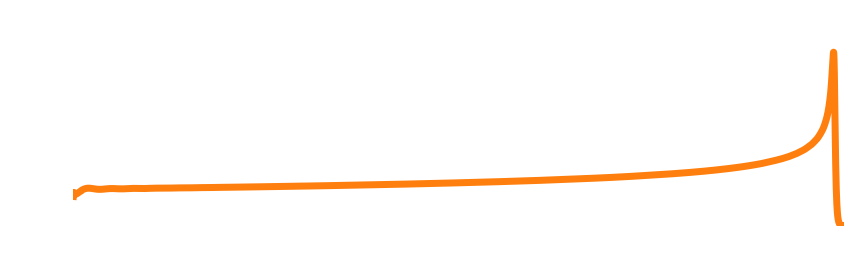

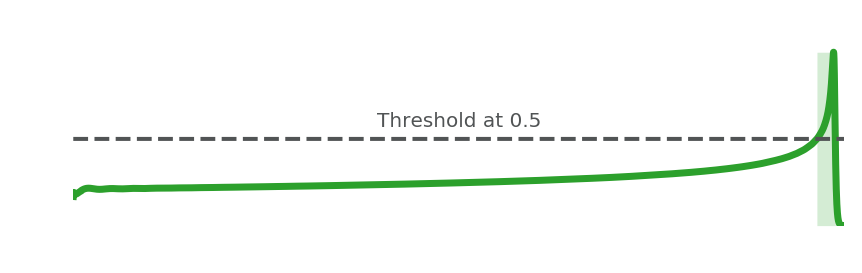

In [11]:
waveform = waveforms['0100_0300'][i]
start, end = get_start_end_idx(waveform)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(waveform[start:end]/np.max(waveform[start:end]), lw=3.5, color='C0')
ax.plot((end-start)*[0], color='#515455', lw=2, ls=':')
ax.set_ylim(-1.2, 1.2)
ax.set_xlim(0, end-start)
ax.axis('off')
fig.set_size_inches(5.354, 1.4448, forward=True)
plt.savefig('waveform.pdf')
plt.show()


envelope = get_envelope(waveform[start:end])
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(envelope/np.max(envelope), lw=3.5, color='C1')
ax.set_ylim(0, 1.2)
ax.set_xlim(0, end-start)
ax.axis('off')
fig.set_size_inches(5.354, 1.4448, forward=True)
plt.savefig('envelope.pdf')
plt.show()


envelope = get_envelope(waveform[start:end])
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(envelope/np.max(envelope), lw=3.5, color='C2')
ax.plot([1/2 for _ in envelope], color='#515455', lw=2, ls='--')
ax.text((end-start)/2, 0.55, 'Threshold at 0.5', va='bottom', ha='center', color='#515455')
ax.set_ylim(0, 1.2)
ax.set_xlim(0, end-start)

THRESHOLD = 0.5
fuzzy_zones = np.zeros(len(envelope))
for j in range(len(envelope)):
    if THRESHOLD < envelope[j]/np.max(envelope):
        fuzzy_zones[j] = 1
ax.fill_between(range(len(envelope)), 0, fuzzy_zones, color='C2', alpha=0.2, lw=0)
    
ax.axis('off')
fig.set_size_inches(5.354, 1.4448, forward=True)
plt.savefig('fwhm-interval.pdf')
plt.show()

## Get the FWHM fuzzy zones for a label vector

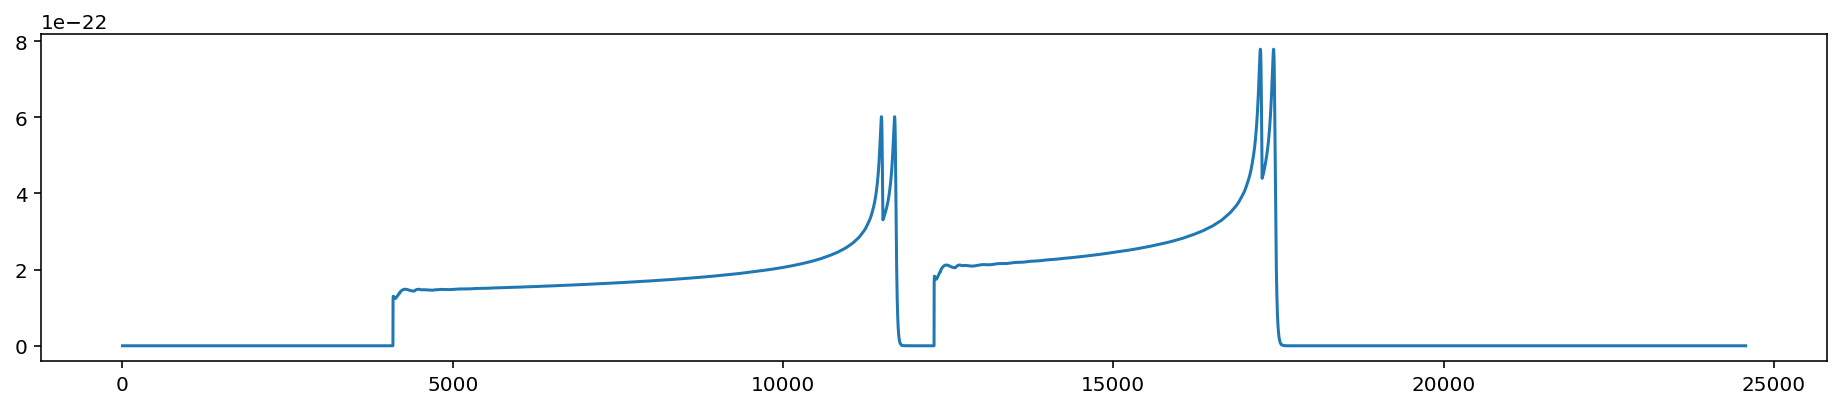

In [20]:
signal = np.zeros(12*2048)
for i in range(2):
    waveform = waveforms[dist][11+i]
    start, end = get_start_end_idx(waveform)
    waveform = waveform[start:end]
    envelope = get_envelope(waveform) 
    signal[(2+i*4)*2048:(2+i*4)*2048+len(envelope)+200] = np.maximum(np.hstack((envelope, np.zeros(200))), np.hstack((np.zeros(200), envelope))) 
    
plt.gcf().set_size_inches(16, 3, forward=True)
plt.plot(signal)

"""
peaks = detect_peaks(signal, mpd=4*2048, edge=None)
print(peaks)
for peak in peaks:
    plt.plot(peak, signal[peak], 'x')
"""

plt.show()

## Get the FWHM of the signal envelope

In [ ]:
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:

    print('DISTANCE: {}'.format(dist))
    
    FWHMs = []
    for i in range(len(waveforms[dist])):

        waveform = waveforms[dist][i]
        start, end = get_start_end_idx(waveform)
        waveform = waveform[start:end]
        envelope = get_envelope(waveform)

        maximum = np.max(envelope)
        FWHM = []
        for j in range(len(envelope)):
            if envelope[j] > 0.5*maximum:
                FWHM.append(j)

        FWHMs.append(len(FWHM))
        
    print('Mean: {:.1f} ± {:.1f}'.format(np.mean(FWHMs), np.std(FWHMs)))
    print('Percentiles (25%/50%/75%): {:.1f} / {:.1f} / {:.1f}'.format(np.percentile(FWHMs, 25), np.percentile(FWHMs, 50), np.percentile(FWHMs, 75)))
    sns.distplot(FWHMs, hist=False, kde_kws={"shade": True})
    plt.axvline(x=np.mean(FWHMs))
    plt.show()
    
    print(79*'-')

## Calculate percentiles of all these waveforms

In [ ]:
percentiles_25 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}
percentiles_50 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}
percentiles_75 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}

for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    
    for idx in range(len(waveforms[dist])):
    
        start, end = get_start_end_idx(waveforms[dist][idx])
        signal = waveforms[dist][idx][start:end]
        envelope = 10**21 * get_envelope(signal)
    
        percentiles_25[dist].append(np.percentile(envelope, 25))
        percentiles_50[dist].append(np.percentile(envelope, 50))
        percentiles_75[dist].append(np.percentile(envelope, 75))

In [ ]:
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    plt.title('Distribution: Percentiles of Signal Envelopes {}'.format(dist))
    sns.distplot(percentiles_25[dist], hist=False, kde_kws={"shade": True}, label='25%')
    sns.distplot(percentiles_50[dist], hist=False, kde_kws={"shade": True}, label='50%')
    sns.distplot(percentiles_75[dist], hist=False, kde_kws={"shade": True}, label='75%')
    plt.axvline(x=0.05, ls=':', color='Gray')
    plt.legend(loc='best')
    plt.xlim(0.0, 2.5)
    plt.ylim(0.0, 5)
    plt.gcf().set_size_inches(8, 6, forward=True)
    plt.show()
